# Movie Recommendation System

Recommendation systems play a central role in many online applications and e-commercial
services such as social networks and product recommendations for films, music, and articles, etc. For companies such as Amazon, eBay, and Netflix, recommendation performance has a huge impact on their commercial success in terms of revenue and user satisfaction.  

The two main types of recommender systems are **Content-Based Filtering** and **Collaborative Filtering (CF)**.

1. Content-based filtering relies on the similarities between the items themselves, that is, between two movies or two songs or two purchased items. 

2. Collaborative filtering produces recommendations based on users’ attitude to items, that is, it uses the “wisdom of the crowd” to recommend items. 
      

In general, Collaborative filtering (CF) is the workhorse of recommender engines since it can perform feature learning on its own, meaning it learns for itself what features to use.   
CF can be divided into _**Memory-Based Collaborative Filtering**_ and _**Model-Based Collaborative filtering**_. 

We will use MovieLens dataset, one of the most common datasets used to implement and test recommender engines. It contains 100,000 movie ratings from 943 users and a selection of 1682 movies. 

The dataset can be found [here](http://files.grouplens.org/datasets/movielens/ml-100k.zip).

In this exercise, we will compare results from memory-based CF, model-based CF and third approach which uses an algorithm called 'Stochastic gradient descent' for collaborative filtering.   
We will evaluate the results using the Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE).

## 1. Exploring the MovieLens 100K Dataset

#### Let's start off by importing useful libraries

In [62]:
# import libraries
import numpy as np
import pandas as pd

import scipy.sparse as sp
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import model_selection as cv
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
from IPython.display import Image
from collections import Counter
from math import sqrt
import warnings
import re

#settings
plt.style.use('seaborn')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings
plt.rcParams["figure.figsize"] = [10,5]

The MovieLens 100K Dataset describes 5-star rating from MovieLens, a movie recommendation service. 

In order to explore the dataset, let's import the files and convert them into dataframes using pandas.

We import the u.data file, which contains the full dataset. You can read a brief description of the dataset [here](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).



In [2]:
#import the datafile and converting it to a pandas dataframe
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('~/Downloads/ml-100k/u.data', sep='\t', names=header)

In [3]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


The 'df' dataset shows the rating that users gave a particular movie

In [4]:
#count the number of unique users and movies
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print('The dataset has ' + str(n_users) + ' users and ' + str(n_items) + ' movies')

The dataset has 943 users and 1682 movies


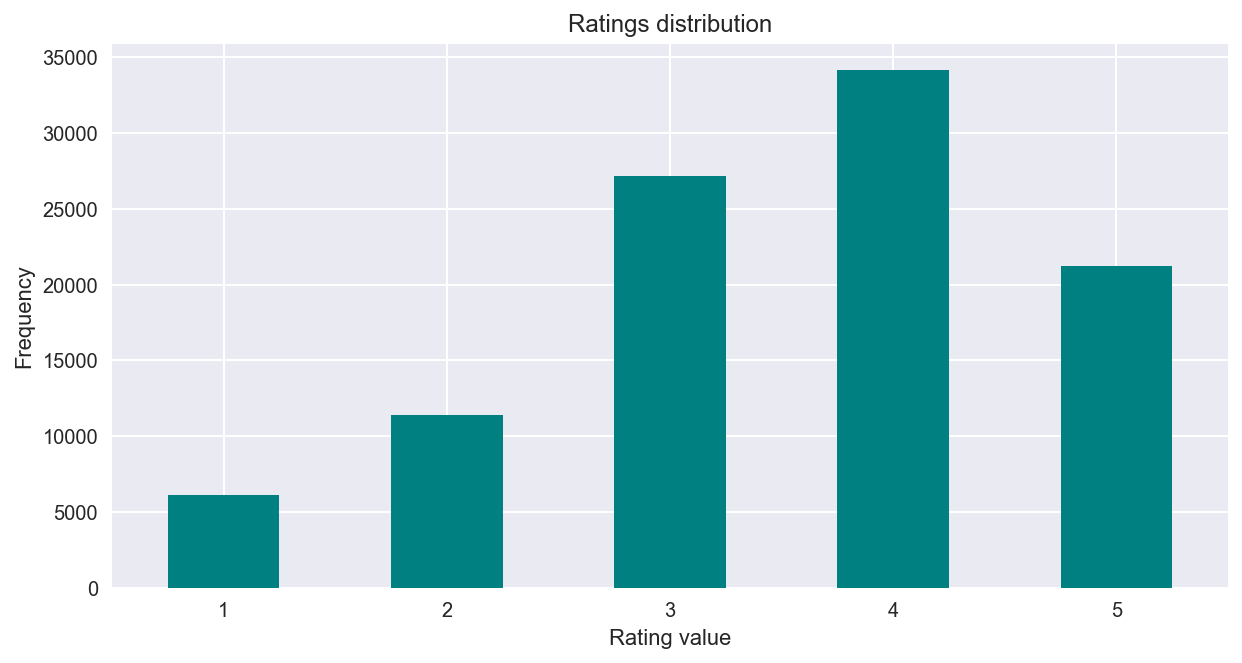

In [51]:
df.groupby('rating').count().plot(kind='bar', color='teal', legend=False)
plt.title("Ratings distribution")
plt.xlabel("Rating value")
plt.ylabel("Frequency")
plt.xticks(rotation=0);

We see that the most common rating value given is a 4.   
Let's take a look at the genres.

In [6]:
#the movies file contains columns indicating the movie genres

m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDB URL',
          'unknown','Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime',
          'Documentry', 'Drama', 'Fantasty', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
          'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('~/Downloads/ml-100k/u.item', sep='|', names= m_cols, encoding='latin-1')

In [7]:
movies.head()

,movie_id,title,release_date,video_release_date,IMDB URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasty,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


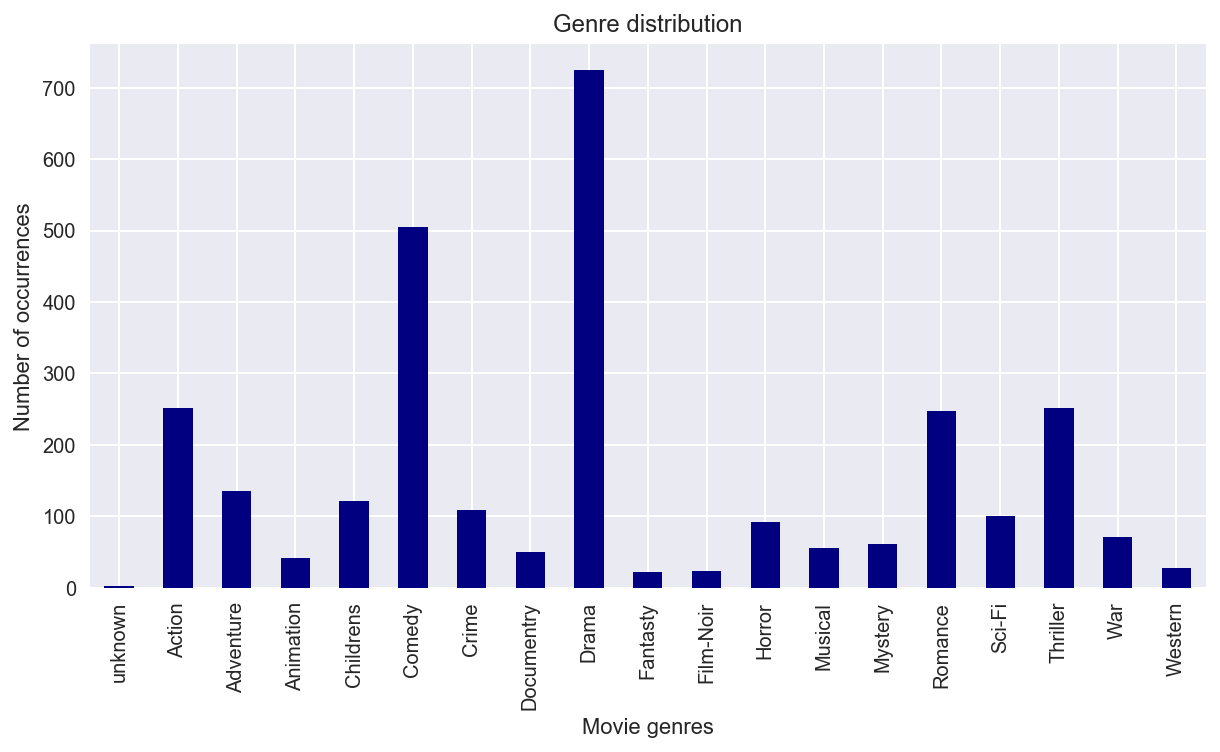

In [50]:
movies_genre = movies.sum(numeric_only=True)
movies_genre = movies_genre.drop(labels=['movie_id','video_release_date'])
plt.xlabel("Movie genres")
plt.ylabel("Number of occurrences")
plt.title("Genre distribution")
movies_genre.plot(kind='bar', color= 'navy');

As we can see from the bar chart, **Drama**, **Comedy**, **Thriller**, **Romance** and **Action** are the five most frequent genres in the MovieLens 100K dataset.

Let's see what were the top rated movies.

In [9]:
#choose only movie titles with above 50 ratings
movie_titles = movies[['movie_id', 'title']]
movie_titles.columns = ['item_id', 'title']
df1 = pd.merge(movie_titles, df, on = 'item_id')
df1= df1.groupby('title').filter(lambda x: len(x) >= 50)
ratings_mean = (df1.groupby('title'))['title','rating'].mean()
ratings_mean.sort_values('rating', ascending=False).head(10)

,rating
title,
"Close Shave, A (1995)",4.491071
Schindler's List (1993),4.466443
"Wrong Trousers, The (1993)",4.466102
Casablanca (1942),4.456790
Wallace & Gromit: The Best of Aardman Animation (1996),4.447761
"Shawshank Redemption, The (1994)",4.445230
Rear Window (1954),4.387560
"Usual Suspects, The (1995)",4.385768
Star Wars (1977),4.358491


Many older recommendation systems will recommend the "Top 10" without paying attention to the user's preferences. However, this is still a good way to deal with the cold start issue when you don't know the user's preferences yet.


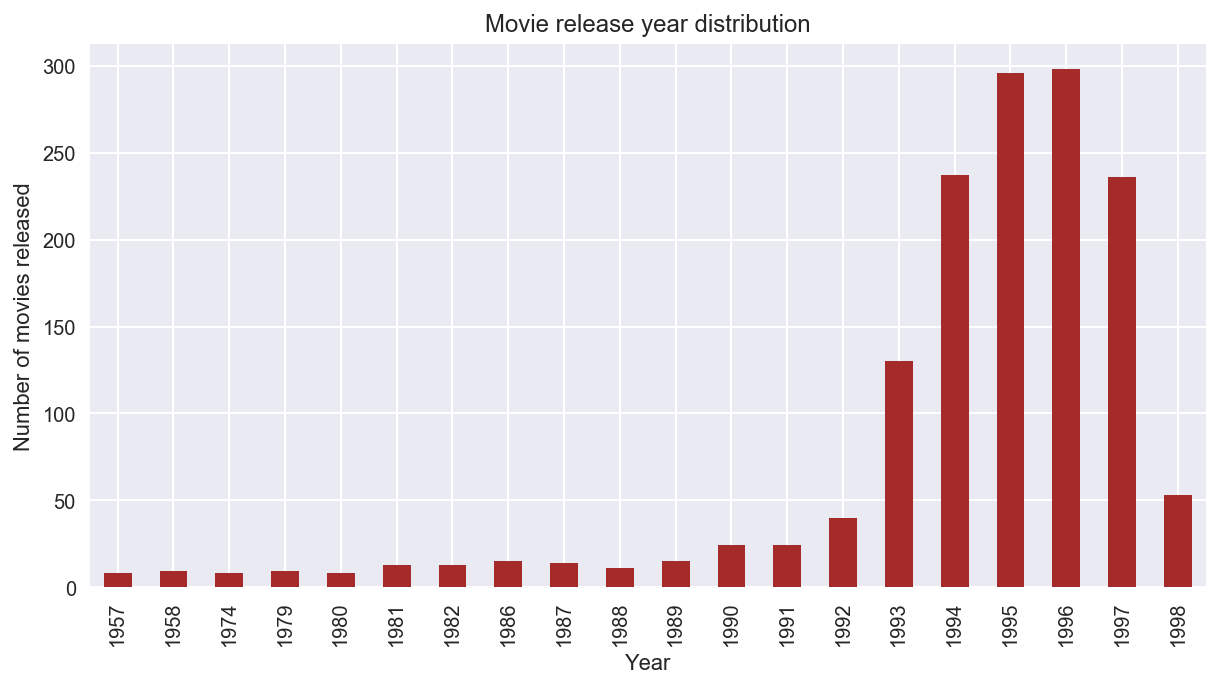

In [52]:
year_list = []
for row in movies["title"]:
    x = re.search(r"\(\d{4}\)", row)
    if x:
        y = x.group(0)
    year_list.append(y[1:-1])

year_count = Counter(year_list)
year_count_30 = year_count .most_common(20)
year_dict = dict(year_count_30)
year_df = pd.DataFrame(year_dict, index=[0])

plt.title("Movie release year distribution")
plt.xlabel("Year")
plt.ylabel("Number of movies released")
year_df.iloc[-1].plot(kind='bar', color='brown');

The data in MovieLens 100K dataset was released in April 1998, so it is reasonable that movies released in 1998 are not represented in the Year distribution bar graph.

## 2. Data Pre-Processing

Let's create helper functions to analyze the data, make empty lists to store the evaluation metrics, and split the dataframe into testing and training sets.

In [11]:
# Create a dictionary to look up movie title from item_id
idx_to_movie = {}
for line in movies.itertuples():
    idx_to_movie[int(line[1])] = line[2]

In [12]:
#Some of the helper functions used to analyze of various recommenders

#Root Mean Squared Error. We will consider only non-zero ratings.
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

#Mean Absolute Error. We will consider only non-zero ratings.

def mae(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_absolute_error(prediction, ground_truth)
 
#Predict function to find user-user similarity and item-item similarity. User bias is removed by adjusting the
#mean user bias before predicting ratings
def predict(ratings, similarity, approach='user',epsilon=1e20):
    if approach == 'user':
        mean_user_rating = ratings.mean(axis=1)
        
#We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif approach == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred
 
#Find the top-k movie names based on the ordered ratings
def top_k_movies_byuser(prediction, mapper, user_idx, k=6):
    return [mapper[x] for x in np.argsort(prediction[user_idx,np.where(train_data_matrix[user_idx, :] == 0)[0]])[:-k-1:-1]]
 
#Predict the ratings using dot product of the latent features for users and items
def predictionSGD(P,Q):
    return np.dot(P.T,Q)

In [13]:
#create empty lists to store the RMSE and MAE for the algorithms
#for evaluation and comparison 

trainRMSE = []
testRMSE = []

trainMAE = []
testMAE = []

In [14]:
#a function to calculate the RMSE and MAE between the prediction matrix and the ground truth, for both test and train matrices
def metrics(trainset, testset, pred):
    m1= round(rmse(pred, trainset),3)
    m2= round(rmse(pred, testset),3)
    m3= round(mae(pred, trainset),3)
    m4= round(mae(pred, testset),3)
    
    trainRMSE.append(m1)
    testRMSE.append(m2)

    trainMAE.append(m3)
    testMAE.append(m4)
        
    print('RMSE on train data: ' + str(m1))
    print('RMSE on test data: ' + str(m2)+ "\n")
    print('MAE on train data: ' + str(m3))
    print('MAE on test data: ' + str(m4))
    
    return (m1,m2,m3,m4)

In [15]:
#print out the recommeneded movies to the user
def print_movies(pred, user_idx):
    print("Movies recommended to user " + str(user_idx) + " are:")
    nearestMovies = top_k_movies_byuser(pred, idx_to_movie, user_idx)
    print(str(nearestMovies)  + "\n")

We can use the scikit-learn library to split the dataset into testing and training. 
This shuffles and splits the data into two datasets according to the percentage of test examples (test_size)
which in this case is 0.25.

We will then get two user-item matrices, train_data_matrix and test_data_matrix.

In [16]:
#split the dataset into testing and training
train_data, test_data = cv.train_test_split(df, test_size=0.25)

In [17]:
#Create two user-item matrices, one for train dataset and another for test dataset
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]

test_data_matrix = np.zeros((n_users, n_items))    
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

## 3. Memory-based Collaborative Filtering

Memory-Based Collaborative Filtering approaches can be divided into two main sections: 
1. User-item filtering - find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. *“Users who are similar to you also liked…”*

2. Item-item filtering - take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations. *“Users who liked this item also liked…”*




A common distance metric is cosine similarity. The metric can be thought of geometrically if one treats a given user's (item's) row (column) of the ratings matrix as a vector. For user-based collaborative filtering, two users' similarity is measured as the cosine of the angle between the two users' vectors.

We can use the pairwise_distances function from sklearn to calculate the cosine similarity.   
The output will range from 0 to 1 since the ratings are all positive.

In [18]:
#Compute the cosine distance and 1-cosine distance yields cosine similarity. 
#epsilon is used to handle the divide by zero scenarios
epsilon=1e-9
user_similarity = (1-pairwise_distances(train_data_matrix, metric='cosine')) + epsilon
item_similarity = (1-pairwise_distances(train_data_matrix.T, metric='cosine')) + epsilon

The next step is to make predictions. 

We have already created similarity matrices: user_similarity and item_similarity.

Therefore, we can make a prediction by applying following formula for user-based CF.


### 3.1 User-based Collaborative filtering 

In [19]:
pred_user_cf = predict(train_data_matrix, user_similarity, approach='user')

In [20]:
userBasedTrainRMSE, userBasedTestRMSE, userBasedTrainMAE, userBasedTestMAE =\
metrics(trainset= train_data_matrix, testset=test_data_matrix, pred=pred_user_cf)

RMSE on train data: 2.897
RMSE on test data: 2.967

MAE on train data: 2.69
MAE on test data: 2.761


We define parameters the user_idx, i.e. the user from the ratings dataframe, who will receive recommendations based on movies he or she has previously rated.

In [21]:
print_movies(user_idx = 30, pred=pred_user_cf)

Movies recommended to user 30 are:
['I.Q. (1994)', 'Silence of the Lambs, The (1991)', 'Delicatessen (1991)', 'Phenomenon (1996)', 'Time to Kill, A (1996)', 'Terminator 2: Judgment Day (1991)']



### 3.2 Item-based Collaborative filtering 

In [22]:
pred_item_cf = predict(train_data_matrix, item_similarity, approach='item')

In [23]:
itemBasedTrainRMSE, itemBasedTestRMSE, itemBasedTrainMAE, itemBasedTestMAE= \
metrics(trainset= train_data_matrix, testset=test_data_matrix, pred = pred_item_cf)

RMSE on train data: 3.097
RMSE on test data: 3.171

MAE on train data: 2.87
MAE on test data: 2.953


In [24]:
print_movies(user_idx = 30, pred=pred_item_cf)

Movies recommended to user 30 are:
['Casino (1995)', 'Children of the Revolution (1996)', 'Anne Frank Remembered (1995)', 'Spanish Prisoner, The (1997)', 'Son in Law (1993)', 'Sliding Doors (1998)']



## 4. Model-based Collaborative filtering

In real world recommendation systems, often even the most active users have rated a very limited percentage of items, when compared to the total available items on a  platform. This leads to sparse user-item matrices, inability to locate successful neighbors and finally, the generation of weak recommendations.

Let's examine the sparsity of our dataframe. 

In [25]:
sparsity=round(1.0-len(df)/float(n_users*n_items),3)
print('The sparsity level of MovieLens100K is ' +  str(sparsity*100) + '%')

The sparsity level of MovieLens100K is 93.7%


Recommendation systems often have a data set with features that define a high dimensional
space, as well as a also very sparse information in that space – i.e. there are
values for a limited number of features per object. 

The notions of density and distance between points, which are critical for clustering and outlier detection, become
less meaningful in highly dimensional spaces. This is known as the 'Curse of Dimensionality'.

Dimensionality reduction techniques help overcome this problem by
transforming the original high-dimensional space into a lower-dimension.

Sparsity and the curse of dimensionality are recurring problems in recommendation systems. Even in
the simplest setting, we are likely to have a sparse matrix with thousands of rows
and columns (i.e. users and items), most of which are zeros. Therefore, dimensionality
reduction comes in naturally.

Model based collaborative filtering uses matrix factorization methods to find the hidden features from the given data. 

Singular Value Decomposition(SVD) is one such matrix factorization methods which we will explore below.

We will use SVD as the matrix factorization method to find the features in the vector space.

In [26]:
#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 30)
s_diag_matrix=np.diag(s)
pred_svd = np.dot(np.dot(u, s_diag_matrix), vt)

The key issue in an SVD decomposition is to find a
lower dimensional feature space where the new features represent “concepts” and
the strength of each concept in the context of the collection is computable. 

The core of the SVD algorithm lies in the following theorem: **It is possible
to decompose a given matrix A into A = UλVT** . Given the n×m matrix data A
(n items, m features), we can obtain an n×r matrix U (n items, r concepts), an r×r
diagonal matrix λ (strength of each concept), and an m×r matrix V (m features, r
concepts). 

The figure below illustrates this idea. The λ diagonal matrix contains the singular values, which will always be positive and sorted in decreasing order. The U
matrix is interpreted as the “item-to-concept” similarity matrix, while the V matrix
is the “term-to-concept” similarity matrix.

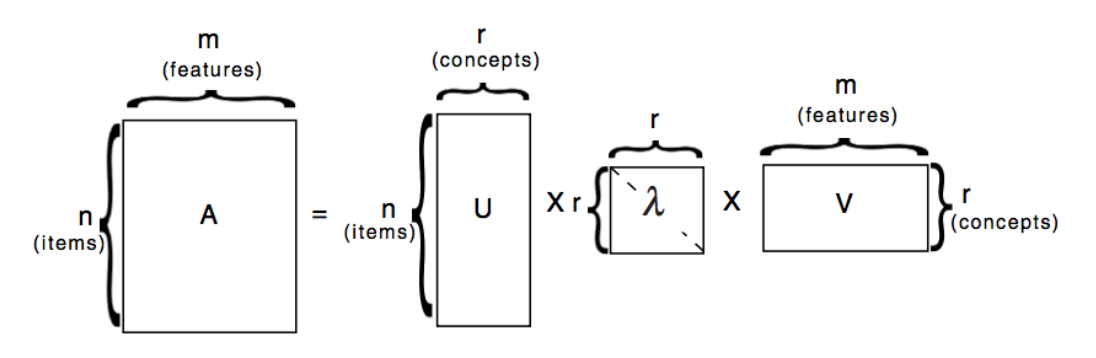

In [53]:
Image(filename='SVD.png', retina=True)

Illustrating the basic Singular Value Decomposition Theorem: **an item ×
features matrix can be decomposed into three different ones: an item × concepts, a
concept strength, and a concept × features.**

(From Ricci, Francesco, Lior Rokach, and Bracha Shapira. "Introduction to recommender systems handbook." Recommender systems handbook. springer US, 2011. 1-35)

In [28]:
modelBasedTrainRMSE, modelBasedTestRMSE, modelBasedTrainMAE, modelBasedTestMAE =\
metrics(trainset= train_data_matrix, testset=test_data_matrix, pred= pred_svd)

RMSE on train data: 2.27
RMSE on test data: 2.805

MAE on train data: 1.982
MAE on test data: 2.542


In [29]:
print_movies(user_idx = 30, pred=pred_svd)

Movies recommended to user 30 are:
['Beauty and the Beast (1991)', 'Tombstone (1993)', 'Return of Martin Guerre, The (Retour de Martin Guerre, Le) (1982)', 'Hunt for Red October, The (1990)', 'Wizard of Oz, The (1939)', 'Time to Kill, A (1996)']



In [46]:
#let's compare the actual ratings to the predicted ratings
num_of_movies = 5
user_idx = 30

In [47]:
# Compare true ratings of user to predictions
ratings = pd.DataFrame(columns = ("Actual Rating","Predicted Rating"))
ratings["Actual Rating"] = train_data_matrix[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:num_of_movies]
ratings["Predicted Rating"] = pred[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:num_of_movies]
print(ratings.round(1))

   Actual Rating  Predicted Rating
0            2.0               3.2
1            4.0               4.1
2            5.0               4.5
3            4.0               4.1
4            3.0               3.6


We see that the model-based collaborative filtering peforms better than the memory based collborative filtering, however, we can should see if we can further improve the results. 
Let's try another approach.

## 5. Stochastic Gradient Descent

In this algorithm we need to find two low-rank matrices, user_feature(k * m) and movie_feature (k*n)
that makes prediction such that loss function is minimized. 

The update function for each step uses the formula in this [paper](http://www.jmlr.org/proceedings/papers/v36/li14.pdf) by Li et. al (2014).

We use regularized stochastic gradient descent to avoid over-fitting and number of iterations are fixed. As the iterations increase RMSE is calculated to arrive at the optimum values of user and movie low rank matrix.

In [32]:
lmbda = 0.1 # Regularization weight
k = 20  # Dimensionality of the latent feature space
m, n = train_data_matrix.shape  # Number of users and items
iterations = 100  # Number of epochs
gamma=0.01  # Learning rate
 
user_feature = 3 * np.random.rand(k,m) # Latent user feature matrix
movie_feature = 3 * np.random.rand(k,n) # Latent movie feature matrix
train_errors_RMSE_SGD = []
test_errors_RMSE_SGD = []
train_errors_MAE_SGD = []
test_errors_MAE_SGD = []

In [33]:
#Only consider non-zero matrix
users,items = train_data_matrix.nonzero()
for iter in range(iterations):
    for u, i in zip(users,items):
        e = train_data_matrix[u, i] - predictionSGD(user_feature[:,u],movie_feature[:,i])  # Calculate error for gradient
        user_feature[:,u] += gamma * ( e * movie_feature[:,i] - lmbda * user_feature[:,u]) # Update latent user feature matrix
        movie_feature[:,i] += gamma * ( e * user_feature[:,u] - lmbda * movie_feature[:,i])  # Update latent movie feature matrix
        
    pred = predictionSGD(user_feature,movie_feature)
    train_rmse = rmse(pred, train_data_matrix)
    test_rmse = rmse(pred, test_data_matrix)
    
    train_mae = mae(pred, train_data_matrix)
    test_mae = mae(pred, test_data_matrix)
    
    train_errors_RMSE_SGD.append(train_rmse)
    test_errors_RMSE_SGD.append(test_rmse)
    train_errors_MAE_SGD.append(train_mae)
    test_errors_MAE_SGD.append(test_mae)

In [34]:
# Calculate prediction matrix R_hat (low-rank approximation for R)
pred_SGD=predictionSGD(user_feature,movie_feature)

In [35]:
#find the RMSE and MAE for the Stochastic Gradient Descent model
sgdBasedTrainRMSE, sgdBasedTestRMSE, sgdBasedTrainMAE, sgdBasedTestMAE =\
metrics(trainset= train_data_matrix, testset=test_data_matrix, pred = pred_SGD)

RMSE on train data: 0.718
RMSE on test data: 0.99

MAE on train data: 0.568
MAE on test data: 0.765


We see a significant improvement in the results compared to the previous models(!)

In [36]:
#Print the evaluation metrics and movie recommendations
print_movies(user_idx = 30, pred=pred_SGD)

Movies recommended to user 30 are:
['Girls Town (1996)', 'Men of Means (1998)', 'Shadow of Angels (Schatten der Engel) (1976)', 'Man from Down Under, The (1943)', 'Open Season (1996)', 'Farmer & Chase (1995)']



In [48]:
#Compare true ratings of user with predictions
ratings = pd.DataFrame(columns = ("Actual Rating","Predicted Rating"))
ratings["Actual Rating"] = train_data_matrix[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:num_of_movies]
ratings["Predicted Rating"] = pred[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:num_of_movies]
print(ratings.round(1))

   Actual Rating  Predicted Rating
0            2.0               3.2
1            4.0               4.1
2            5.0               4.5
3            4.0               4.1
4            3.0               3.6


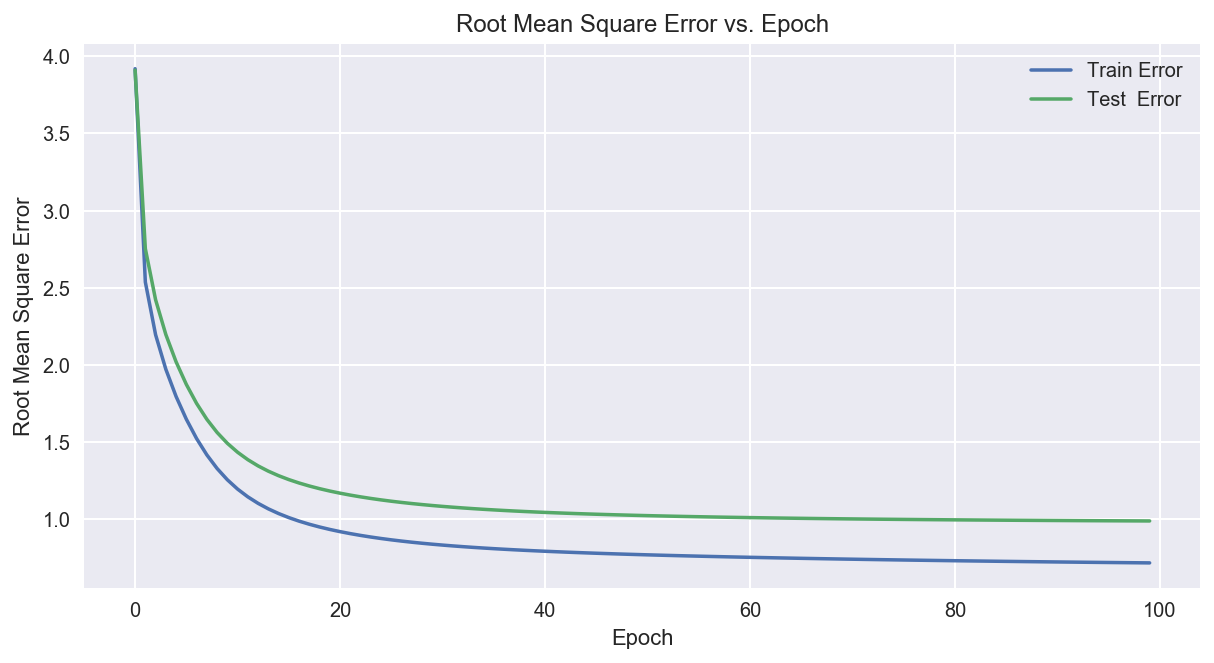

In [54]:
plt.plot(train_errors_RMSE_SGD, label='Train Error')
plt.plot(test_errors_RMSE_SGD, label='Test  Error')
plt.title("Root Mean Square Error vs. Epoch")
plt.xlabel('Epoch')
plt.ylabel('Root Mean Square Error')
plt.legend(loc='best')
plt.show()

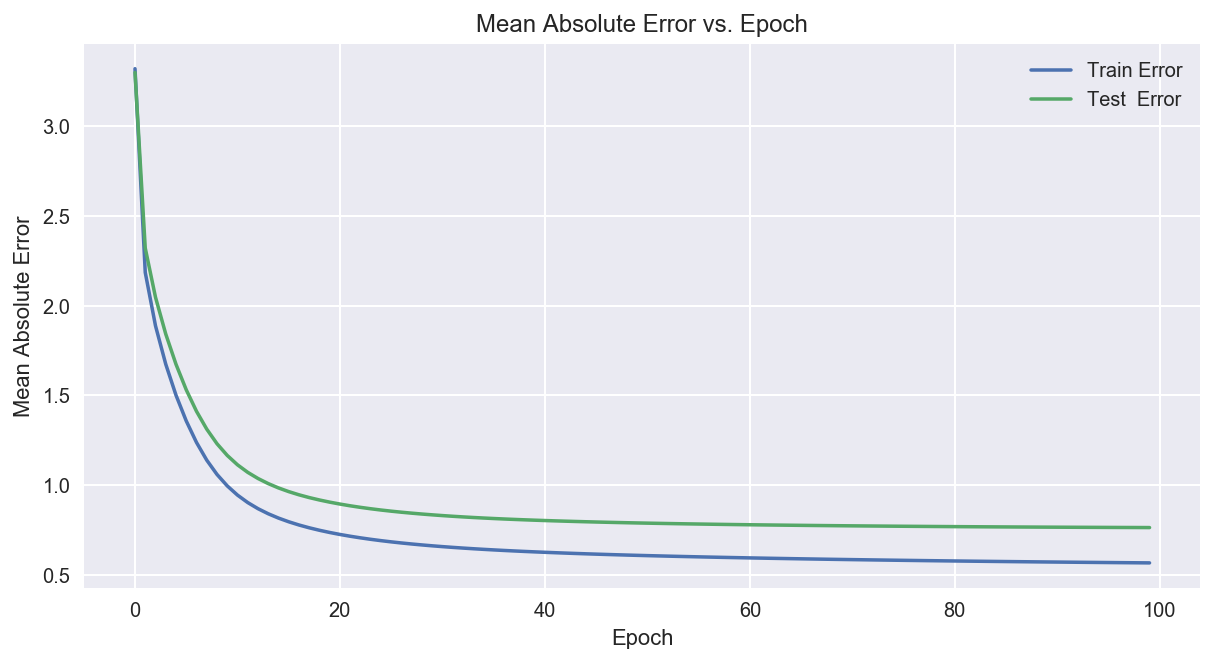

In [55]:
plt.plot(train_errors_MAE_SGD, label='Train Error')
plt.plot(test_errors_MAE_SGD, label='Test  Error')
plt.title("Mean Absolute Error vs. Epoch")
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')
plt.show()

The train_errors and test_errors graphs indicate that 100 epochs were sufficent in reducing the root mean square error and since we see a plateau in the error decline, we can deduce that a larger iterations variable would not significantly reduce the root mean square error.

### Additional Test Cases

Let's try the same SGD with different hyperparameters. We can start by defining a helper function to run this model.

In [40]:
def runSGD(lmbda,k,iterations,gamma):
    
    m, n = train_data_matrix.shape  # Number of users and items
    user_feature = 3 * np.random.rand(k,m) # Latent user feature matrix
    movie_feature = 3 * np.random.rand(k,n) # Latent movie feature matrix
    train_errors = []
    test_errors = []

    #Only consider non-zero matrix
    users,items = train_data_matrix.nonzero()
    for iter in range(iterations):
        for u, i in zip(users,items):
            e = train_data_matrix[u, i] - predictionSGD(user_feature[:,u],movie_feature[:,i])  # Calculate error for gradient
            user_feature[:,u] += gamma * ( e * movie_feature[:,i] - lmbda * user_feature[:,u]) # Update latent user feature matrix
            movie_feature[:,i] += gamma * ( e * user_feature[:,u] - lmbda * movie_feature[:,i])  # Update latent movie feature matrix

        pred = predictionSGD(user_feature,movie_feature)
        train_rmse = rmse(pred, train_data_matrix)
        test_rmse = rmse(pred, test_data_matrix)
        train_errors.append(train_rmse)
        test_errors.append(test_rmse)
        
    pred=predictionSGD(user_feature,movie_feature)

    print('User-based SGD RMSE on train data: ' + str(round(rmse(pred, train_data_matrix),3)))
    print('User-based SGD RMSE on test data: ' + str(round(rmse(pred, test_data_matrix),3)) + "\n")

    print('User-based SGD MAE on train data: ' + str(round(mae(pred, train_data_matrix),3)))
    print('User-based SGD MAE on test data: ' + str(round(mae(pred, test_data_matrix), 3)) + "\n")

In [41]:
runSGD(lmbda = 0.2, k = 20, iterations = 100, gamma=0.01)

User-based SGD RMSE on train data: 0.898
User-based SGD RMSE on test data: 0.991

User-based SGD MAE on train data: 0.722
User-based SGD MAE on test data: 0.785



We see that increasing the lambda value does not improve the results on the test set.

In [42]:
runSGD(lmbda = 0.05, k = 20, iterations = 100, gamma=0.01)

User-based SGD RMSE on train data: 0.623
User-based SGD RMSE on test data: 1.06

User-based SGD MAE on train data: 0.485
User-based SGD MAE on test data: 0.805



Decreasing the lambda value caused the model to be even more prone to overfitting. 

Let's see if doubling the number of iterations will improve the model.

In [43]:
runSGD(lmbda = 0.1, k = 20, iterations = 200, gamma=0.01)

User-based SGD RMSE on train data: 0.683
User-based SGD RMSE on test data: 0.972

User-based SGD MAE on train data: 0.54
User-based SGD MAE on test data: 0.753



As the graph for 100 iterations showed, the improvement from 100 to 200 iterations was marginal.   

## 6. Model Performance

According to "Shani, Guy, and Asela Gunawardana. "Evaluating recommendation systems." Recommender systems handbook (2011): 257-297."
RMSE and MAE are the two most common evaluation metrics for recommendation systems.

Let's plot the results of these metrics for the model's we've implemented:

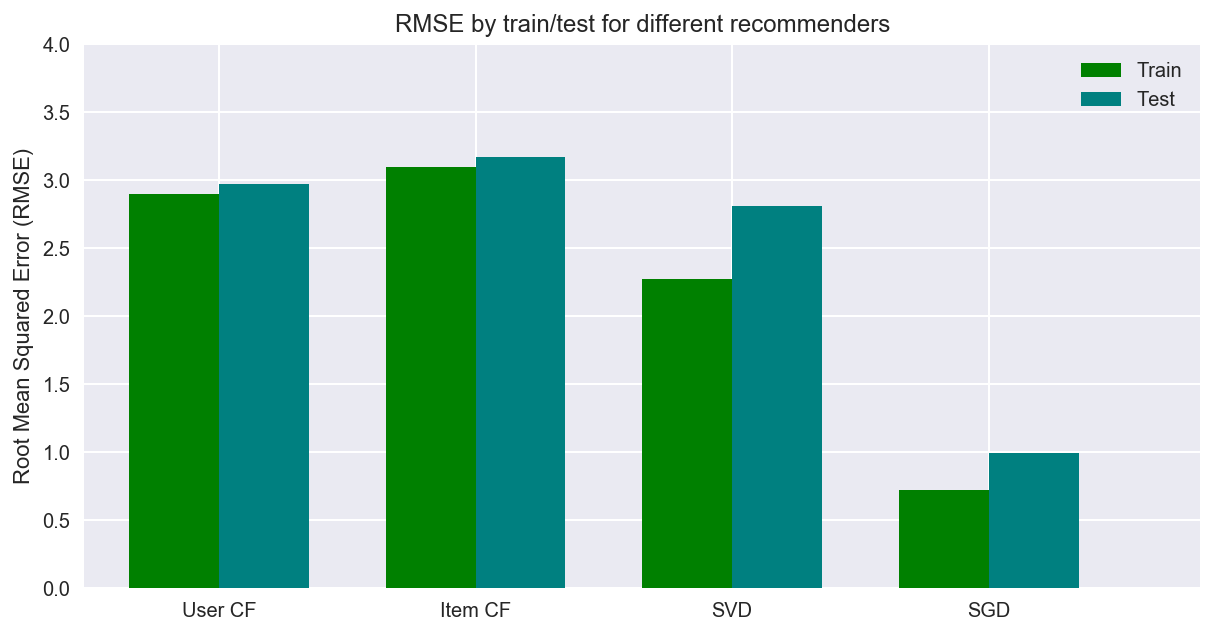

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)
 
# the data
N = 4

# necessary variables
index = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars
opacity = 0.8

## the bars
rects1 = ax.bar(index, trainRMSE[0:4], width, color='green')
rects2 = ax.bar(index+width, testRMSE[0:4], width, color='teal')
 
# axes and labels
ax.set_xlim(-width,len(index))
ax.set_ylim(0,4)
ax.set_ylabel('Root Mean Squared Error (RMSE)')
ax.set_title('RMSE by train/test for different recommenders')
xTickMarks = ['User CF','Item CF','SVD','SGD']
ax.set_xticks(index+width/2)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, fontsize=10)

## add a legend
ax.legend((rects1[0], rects2[0]), ('Train', 'Test'))

plt.show()

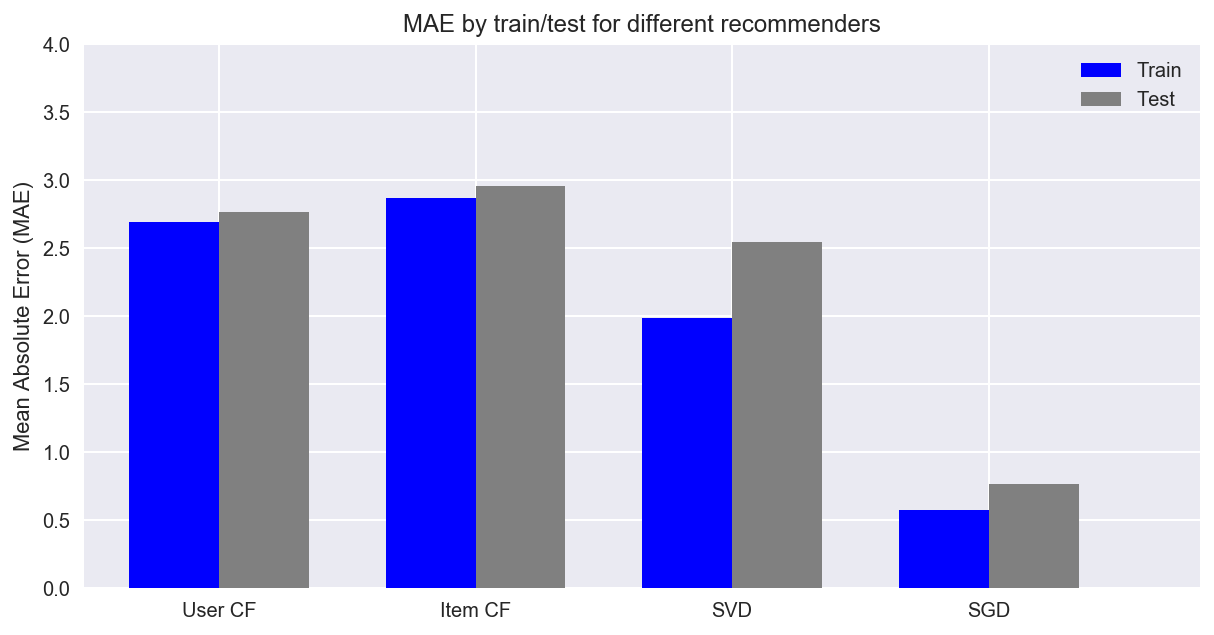

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
 
# the data
N = 4

# necessary variables
index = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars
opacity = 0.8

## the bars
rects1 = ax.bar(index, trainMAE[0:4], width, color='blue')
rects2 = ax.bar(index+width, testMAE[0:4], width, color='grey')
 
# axes and labels
ax.set_xlim(-width,len(index))
ax.set_ylim(0,4)
ax.set_ylabel('Mean Absolute Error (MAE)')
ax.set_title('MAE by train/test for different recommenders')
xTickMarks = ['User CF','Item CF','SVD','SGD']
ax.set_xticks(index+width/2)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, fontsize=10)

## add a legend
ax.legend((rects1[0], rects2[0]), ('Train', 'Test'))

plt.show()

## 7. Conclusions, Limitations, and Future Steps

In this exercise we implemented simple Collaborative Filtering methods, both memory-based CF and model-based CF as well as the Stochastic Gradient Descent approach.

Memory-based models are based on similarity between items or users, where we use cosine-similarity as the distance metric.
Model-based CF is based on matrix factorization where we used SVD to factorize the matrix.

We evaluated model performance with Root Mean Square Error (RMSE) and Mean Absolute Error (MAE). 

**Stochastic Gradient Descent outperformed other collaborative filtering methods with the least RMSE and MAE.** 

Models used by Netflix, Pandora and Facebook, all use a combination of the recommender systems, also known as *Hybrid recommendation systems*. These models depend upon the features of the object itself as well as the preferences of other users.

Additionally, different algorithms can be combined to provide a single rating, which takes advantage of the strengths of each model. These are called ensemble methods. They proved successful in the Netflix Prize competition in 2009, where the top algorithm had a RMSE of 0.8554, versus Netflix's 'Cinematch' algorithm with a RMSE of 0.9514 at the time.  

Another way to improve the current model is by tuning hyperparameter of the Stocastic Gradient Descent model, including: regularization weight, dimensionality of the latent feature space (k), the number of epochs, and learning rate. Future steps could include a grid search algorithm to find the best combination of these hyperparameters.

Furthermore, it would be worthwile to try these models on the larger MovieLens 1M, 10M, and 20M datasets, to see whether the additional datapoints improve the model. [SurpriseLib](http://surpriselib.com/), a Python library for recommendation systems, compares various algorithms on the 100K and 1M datasets. Intuitively, all models preformed better on the 1M dataset compared to the 100K dataset. 

Based off of the Netflix Prize competition experience, the most accurate model is not neccesarily the best one for production use. Additional algorithms such as those available in the SurpriseLib library, for example Co-clustering and Slope One, could offer an accurate, yet computationaly inexpensive model, as observed by their execution time. 

Finally, building recommender systems that perform well in cold-start scenarios (where little data is availabe on new users and items) remains a challenge. This limitation should be taken into account, when designing recommendation systems with little data.